In [1]:
import os
import time
import yaml
import base64

import networkx as nx

from openai import OpenAI

from typing import List, Tuple
from pydantic import BaseModel

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

In [2]:
##### Setup paths and openai api key
def get_openai_key(path_to_secrets):
    openai_api_key = None
    try:
        with open(path_to_secrets, "r") as file:
            secrets = yaml.safe_load(file)
            openai_api_key = secrets["openai_api_key"]
    except Exception as e:
        print(f"[ERROR]: {e}")

    return openai_api_key

PATH_TO_DATA_DIR = os.path.join(
    os.getcwd(),
    "data",
    "processed"
)
PATH_TO_IMAGES_DIR = os.path.join(
    os.getcwd(),
    "data",
    "images"
)

FILENAME = "2021Bouza_cleaned_for_llm.txt"

IMAGE_FILENAMES = [
    "2021Bouza_fig1.png",
    "2021Bouza_fig5.png",
    "2021Bouza_table2.png"
]

path_to_text = os.path.join(PATH_TO_DATA_DIR, FILENAME)

paths_to_images = []
for fname in IMAGE_FILENAMES:
    paths_to_images.append(os.path.join(PATH_TO_IMAGES_DIR, fname))

with open(path_to_text, "r") as file:
    raw_text = file.read()

OPENAI_API_KEY = get_openai_key(os.path.join(os.getcwd(), ".secrets.yml"))

In [3]:
##### Openai MODEL_COST, MODEL_ALIASES, and cost helper
def get_cost_multiples(model_cost, model_aliases):
    cost_multiples = []
    for model, true_model in model_aliases.items():
        input_cost = model_cost[true_model]["cost_per_mil_input_tokens"]
        cost_multiples.append([input_cost, model])

    cost_multiples.sort()

    minimum_cost = min(cost[0] for cost in cost_multiples)
    for i in range(len(cost_multiples)):
        multiple = cost_multiples[i][0] / minimum_cost
        multiple = round(multiple * 2) / 2
        cost_multiples[i][0] = multiple

    return cost_multiples

MODEL_ALIASES = {
    "gpt-4.1": "gpt-4.1-2025-04-14",
    "gpt-4.1-mini": "gpt-4.1-mini-2025-04-14",
    "gpt-4.1-nano": "gpt-4.1-nano-2025-04-14",
    "gpt-4o": "gpt-4o-2024-08-06",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "o3-pro": "o3-pro-2025-06-10",
    "o3": "o3-2025-04-16",
    "o3-mini": "o3-mini-2025-01-31",
    "o4-mini": "o4-mini-2025-04-16"
}
ALIAS_FROM_TRUE_MODEL = {v: k for k, v in MODEL_ALIASES.items()}
MODEL_COST = {
    "gpt-4.1-2025-04-14": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "gpt-4.1-mini-2025-04-14": {"cost_per_mil_input_tokens": 0.40, "cost_per_mil_output_tokens": 1.60},
    "gpt-4.1-nano-2025-04-14": {"cost_per_mil_input_tokens": 0.10, "cost_per_mil_output_tokens": 0.40},
    "gpt-4o-2024-08-06": {"cost_per_mil_input_tokens": 2.50, "cost_per_mil_output_tokens": 10.00},
    "gpt-4o-mini-2024-07-18": {"cost_per_mil_input_tokens": 0.15, "cost_per_mil_output_tokens": 0.60},
    "o3-pro-2025-06-10": {"cost_per_mil_input_tokens": 20.00, "cost_per_mil_output_tokens": 80.00},
    "o3-2025-04-16": {"cost_per_mil_input_tokens": 2.00, "cost_per_mil_output_tokens": 8.00},
    "o3-mini-2025-01-31": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
    "o4-mini-2025-04-16": {"cost_per_mil_input_tokens": 1.10, "cost_per_mil_output_tokens": 4.40},
}

cost_multiples = get_cost_multiples(MODEL_COST, MODEL_ALIASES)
for multiple, model in cost_multiples:
    print(f"{multiple}: {model}")

1.0: gpt-4.1-nano
1.5: gpt-4o-mini
4.0: gpt-4.1-mini
11.0: o3-mini
11.0: o4-mini
20.0: gpt-4.1
20.0: o3
25.0: gpt-4o
200.0: o3-pro


In [4]:
##### Helpers
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def print_response_stats(response):
    print(f"Response alias model: {ALIAS_FROM_TRUE_MODEL[response.model]}")
    print(f"Response true model: {response.model}")
    print(f"Response input tokens: {response.usage.input_tokens}")
    print(f"Response output tokens: {response.usage.output_tokens}")

    # Cost calculation
    input_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_input_tokens"]
    output_cost_per_mil = MODEL_COST[response.model]["cost_per_mil_output_tokens"]
    input_token_cost = (response.usage.input_tokens / 1_000_000) * input_cost_per_mil
    output_token_cost = (response.usage.output_tokens / 1_000_000) * output_cost_per_mil
    total_cost = input_token_cost + output_token_cost

    print(f"Estimated input token cost: ${input_token_cost:.4f}")
    print(f"Estimated output token cost: ${output_token_cost:.4f}")
    print(f"Total estimated cost: ${total_cost:.4f}")

In [17]:
def extract_sro_from_text(raw_text, prompt_text, client, model, ExtractionTemplate, provenance_tag="text"):
    """Extract SROs from text, tagging each with provenance."""
    messages = [{"role": "user", "content": prompt_text}]
    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=ExtractionTemplate
    )
    print("[Text Extraction]")
    print_response_stats(response)
    rdict = response.output_parsed.model_dump()
    SRO_keys = ["subject", "subject_type", "relation", "relation_type", "object", "object_type"]
    triples = []
    for sro in rdict["subject_relation_object"]:
        row = [sro[key] for key in SRO_keys]
        row.append(provenance_tag)
        triples.append(row)
    print(f"SROs extracted from text: {len(triples)}")
    return triples

def extract_sro_from_image(image_path, prompt, client, model, ExtractionTemplate, provenance_tag=None):
    """Extract SROs from an image, tagging with provenance (image filename by default)."""
    base64_image = encode_image(image_path)
    messages = [
        {"role": "user",
         "content": [
             {"type": "input_text", "text": prompt},
             {"type": "input_image", "image_url": f"data:image/png;base64,{base64_image}"}
         ]}
    ]
    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=ExtractionTemplate
    )
    print(f"[Image Extraction] {os.path.basename(image_path)}")
    print_response_stats(response)
    rdict = response.output_parsed.model_dump()
    SRO_keys = ["subject", "subject_type", "relation", "relation_type", "object", "object_type"]
    triples = []
    tag = provenance_tag or os.path.splitext(os.path.basename(image_path))[0]
    for sro in rdict["subject_relation_object"]:
        row = [sro[key] for key in SRO_keys]
        row.append(tag)
        triples.append(row)
    print(f"SROs extracted from {os.path.splitext(image_path.split('/')[-1])[0]}: {len(triples)}")
    return triples


In [19]:
##### Define response structure with pydantic classes and generate prompts
class SROWithMetadata(BaseModel):
    subject: str
    subject_type: str | None
    relation: str
    relation_type: str | None
    object: str
    object_type: str | None

class ExtractionTemplate(BaseModel):
    subject_relation_object: list[SROWithMetadata]

prompt_text = f"""
I am building a structured knowledge graph from the technical content of this academic paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.

**Text:**
{raw_text}
"""

prompt_image = f"""
I am building a structured knowledge graph from the technical content of an academic paper on EUV spectroscopy. Here is a figure from the paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.
"""

In [20]:
##### Setup enviornment for openai call
model_alias = "gpt-4.1"
true_model = MODEL_ALIASES[model_alias]
print(f"True model: {true_model}")

messages = [
        {"role": "user", "content": prompt_text},
    ]
client = OpenAI(api_key=OPENAI_API_KEY)

True model: gpt-4.1-2025-04-14


In [21]:
# Extract text SROs
SRO_list = extract_sro_from_text(raw_text, prompt_text, client, true_model, ExtractionTemplate, provenance_tag="text")

# Extract image SROs
for img_path in paths_to_images:
    SRO_list += extract_sro_from_image(img_path, prompt_image, client, true_model, ExtractionTemplate)

[Text Extraction]
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 12982
Response output tokens: 1861
Estimated input token cost: $0.0260
Estimated output token cost: $0.0149
Total estimated cost: $0.0409
SROs extracted from text: 31
[Image Extraction] 2021Bouza_fig1.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1302
Response output tokens: 506
Estimated input token cost: $0.0026
Estimated output token cost: $0.0040
Total estimated cost: $0.0067
SROs extracted from 2021Bouza_fig1: 9
[Image Extraction] 2021Bouza_fig5.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1642
Response output tokens: 408
Estimated input token cost: $0.0033
Estimated output token cost: $0.0033
Total estimated cost: $0.0065
SROs extracted from 2021Bouza_fig5: 7
[Image Extraction] 2021Bouza_table2.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Re

In [23]:
def build_kg(SRO_list):
    """Construct a DiGraph from a list of SROs (with provenance)."""
    G = nx.DiGraph()
    for s, s_type, r, r_type, o, o_type, source in SRO_list:
        G.add_node(s, ntype=s_type, source=source)
        G.add_node(o, ntype=o_type, source=source)
        G.add_edge(s, o, label=r, rtype=r_type, source=source)
    return G

def filter_SROs_by_source(SRO_list, include=None, exclude=None):
    """Return only SROs whose source is in include or not in exclude."""
    if include:
        return [sro for sro in SRO_list if sro[6] in include]
    if exclude:
        return [sro for sro in SRO_list if sro[6] not in exclude]
    return SRO_list

def filter_SROs_by_subject(SRO_list, subject):
    """Return all SROs with a given subject (can expand to BFS subgraph later)."""
    return [sro for sro in SRO_list if sro[0] == subject]

In [24]:
G = build_kg(SRO_list)

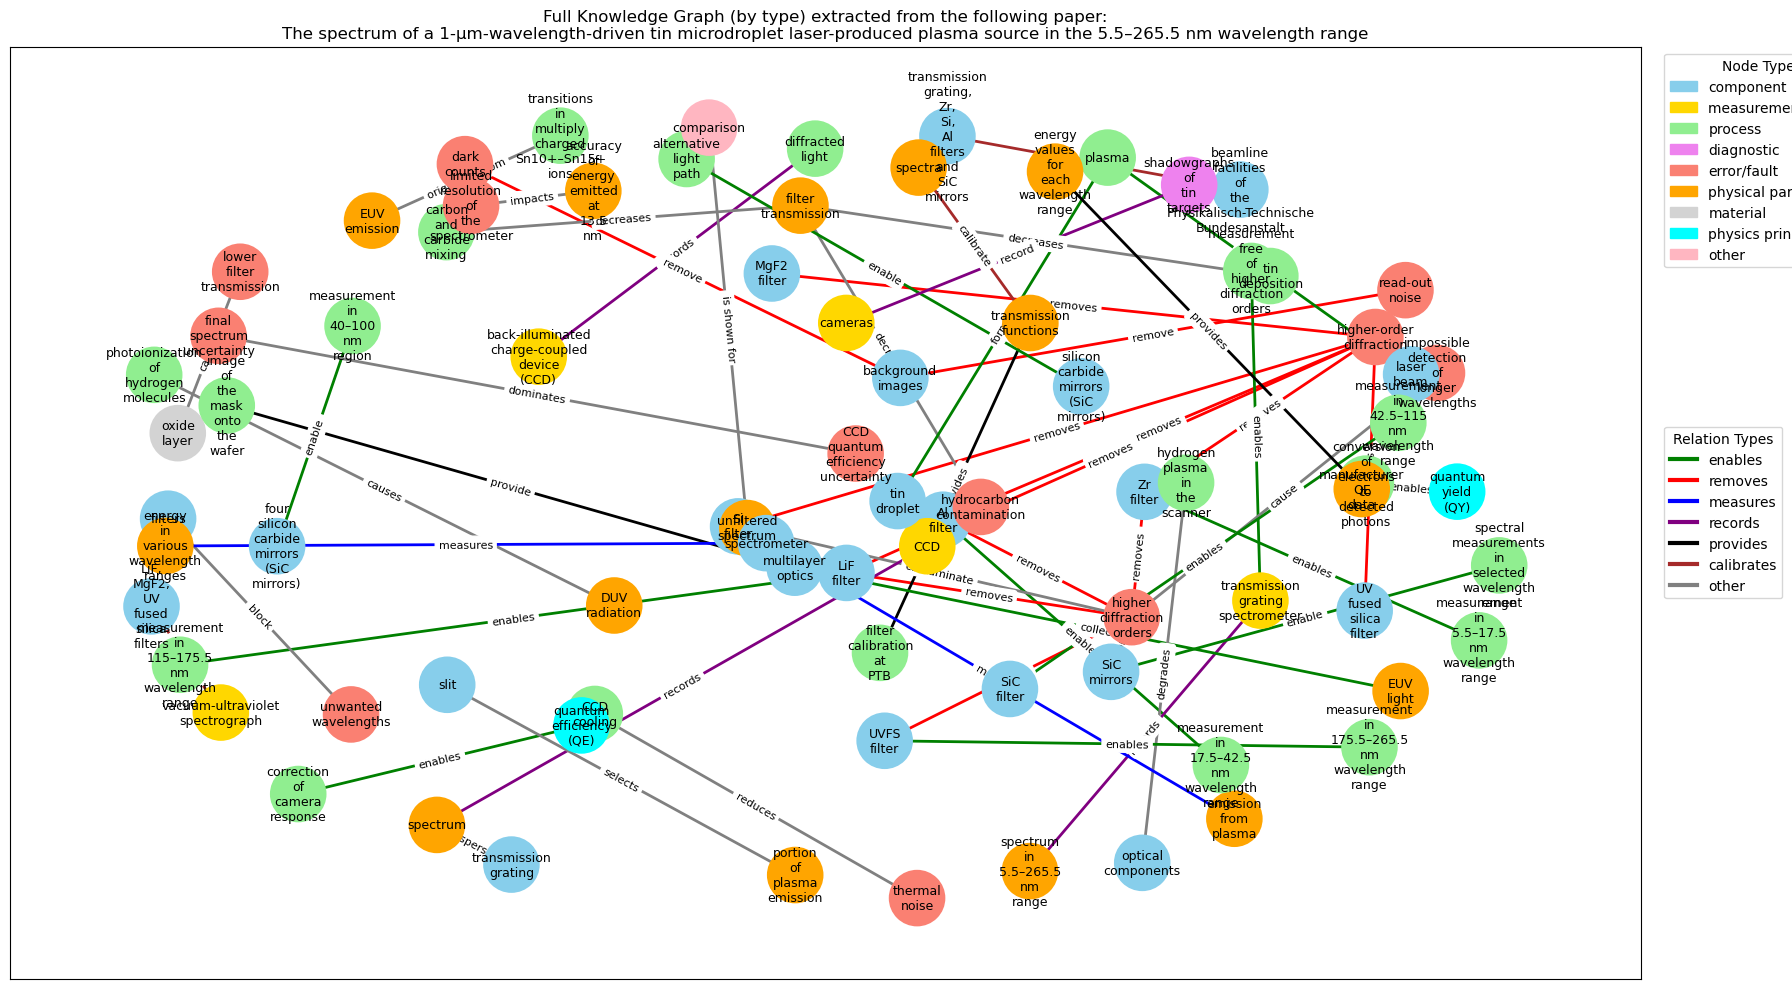

In [30]:
def plot_kg(
    G,
    title="Knowledge Graph",
    highlight_sources=None,
    highlight_nodes=None,
    highlight_edges=None,
    node_type_color=None,
    edge_type_color=None,
    provenance_color="lime",
    highlight_provenance=False
):
    """
    Plots a KG. Options to highlight nodes/edges by source/provenance/type.
    highlight_sources: list of sources to highlight (edges/nodes)
    highlight_nodes: list of node names to highlight
    highlight_edges: list of (s, o) tuples to highlight
    highlight_provenance: if True, color border of nodes by provenance
    """

    plt.figure(figsize=(18, 10))
    pos = nx.spring_layout(G, k=0.6, seed=42)

    node_colors = []
    border_colors = []
    for n in G.nodes:
        ntype = G.nodes[n].get("ntype")
        source = G.nodes[n].get("source")
        # Color by type
        c = node_type_color.get(ntype, "grey") if node_type_color else "grey"
        node_colors.append(c)
        # Border color by provenance
        if highlight_provenance and highlight_sources and source in highlight_sources:
            border_colors.append(provenance_color)
        else:
            border_colors.append("black")

    labels = {n: str(n).replace(" ", "\n") for n in G.nodes}
    # Draw nodes (with border)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, linewidths=2, edgecolors=None)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # Edge colors
    edge_colors = []
    for e in G.edges:
        edge_source = G.edges[e].get("source")
        # Highlight certain sources
        if highlight_sources and edge_source in highlight_sources:
            edge_colors.append(provenance_color)
        elif highlight_edges and e in highlight_edges:
            edge_colors.append(provenance_color)
        else:
            rtype = G.edges[e].get("rtype")
            edge_colors.append(edge_type_color.get(rtype, "grey") if edge_type_color else "grey")

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    
    # Node type legend
    legend_handles_nodes = [Patch(color=clr, label=lbl) for lbl, clr in node_type_color.items() if lbl]

    # Edge/relation type legend
    legend_handles_edges = [Line2D([0], [0], color=clr, lw=3, label=lbl)
                            for lbl, clr in edge_type_color.items() if lbl]

    # Place both legends
    # Place the node legend first and add it as an artist
    legend1 = plt.legend(handles=legend_handles_nodes, title="Node Types", loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.gca().add_artist(legend1)

    # Now add the edge legend (will appear just below the node legend)
    legend2 = plt.legend(handles=legend_handles_edges, title="Relation Types", loc='upper left', bbox_to_anchor=(1.01, 0.60))
    
    plt.tight_layout()
    plt.show()

# Define your colors as before
type_color = {
    "component": "skyblue", "measurement device": "gold", "process": "lightgreen",
    "diagnostic": "violet", "error/fault": "salmon", "physical parameter": "orange",
    "material": "lightgrey", "physics principle": "aqua", "other": "lightpink", None: "grey"
}
relation_color = {
    "enables": "green", "removes": "red", "measures": "blue", "records": "purple",
    "provides": "black", "calibrates": "brown", "other": "grey", None: "grey"
}

paper_title = "The spectrum of a 1-μm-wavelength-driven tin microdroplet laser-produced plasma source in the 5.5–265.5 nm wavelength range"
plot_kg(G, title=f"Full Knowledge Graph (by type) extracted from the following paper:\n{paper_title}", node_type_color=type_color, edge_type_color=relation_color)

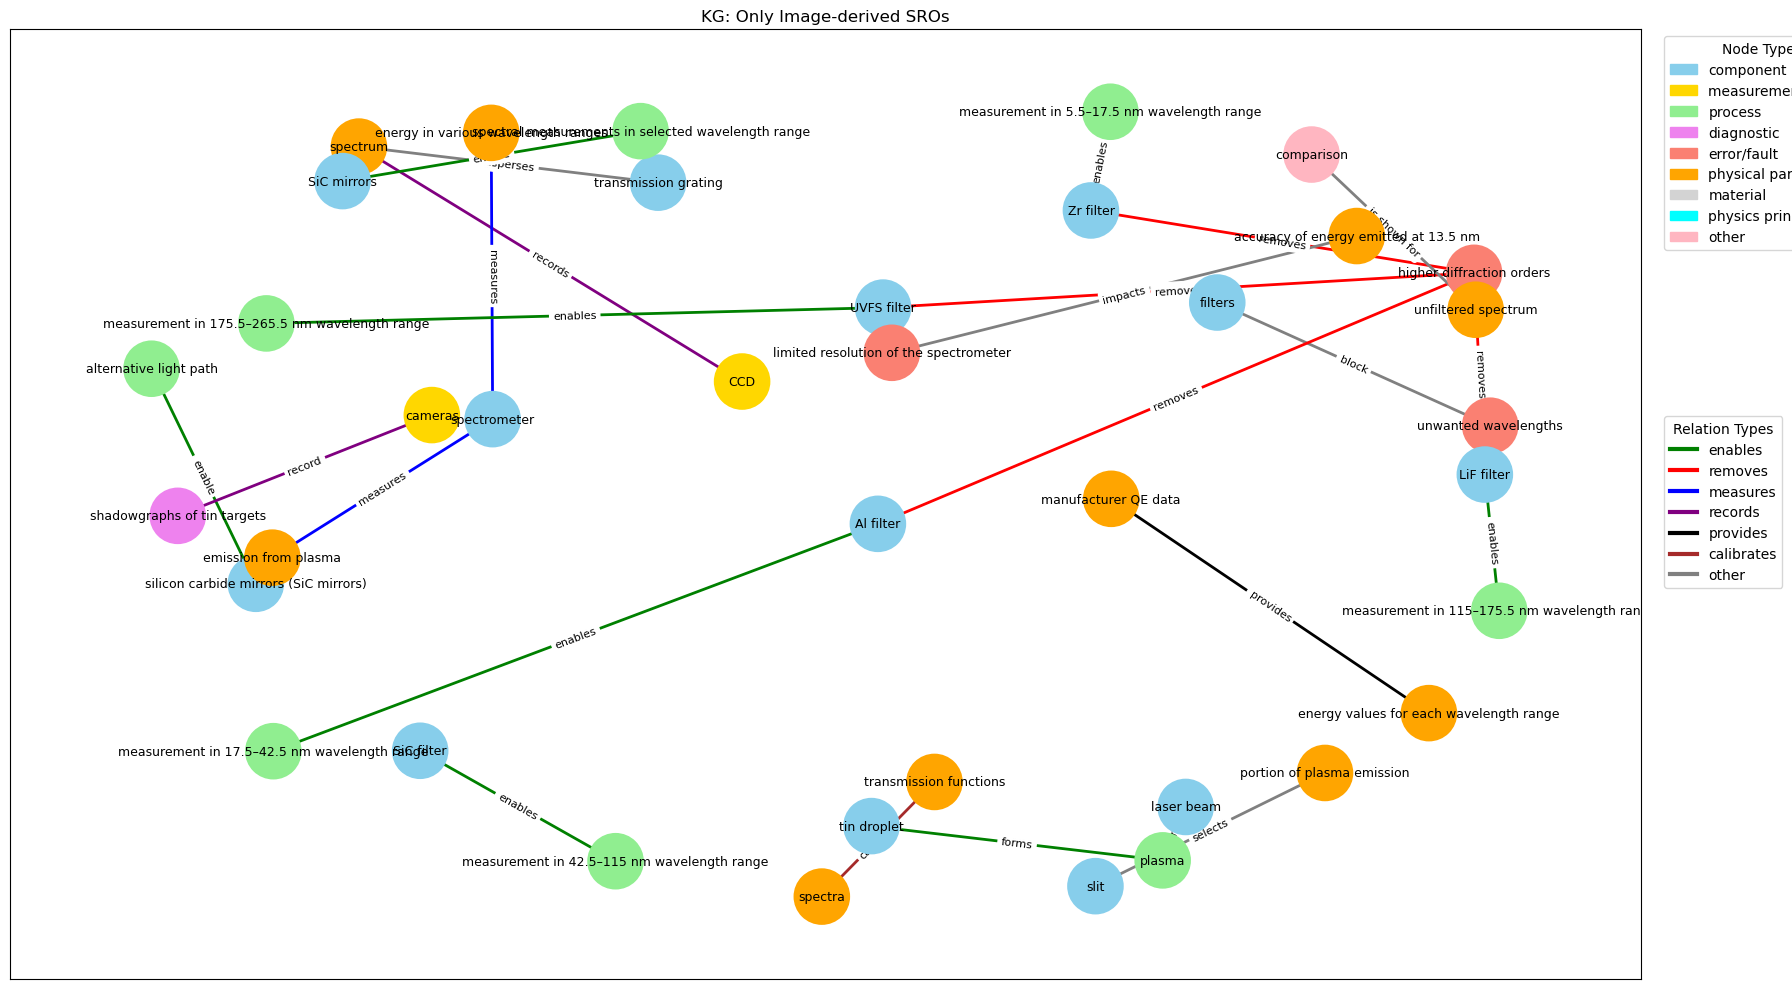

In [28]:
image_sources = [os.path.splitext(os.path.basename(f))[0] for f in paths_to_images]
SRO_image = filter_SROs_by_source(SRO_list, include=image_sources)
G_img = build_kg(SRO_image)
plot_kg(G_img, title="KG: Only Image-derived SROs", node_type_color=type_color, edge_type_color=relation_color)


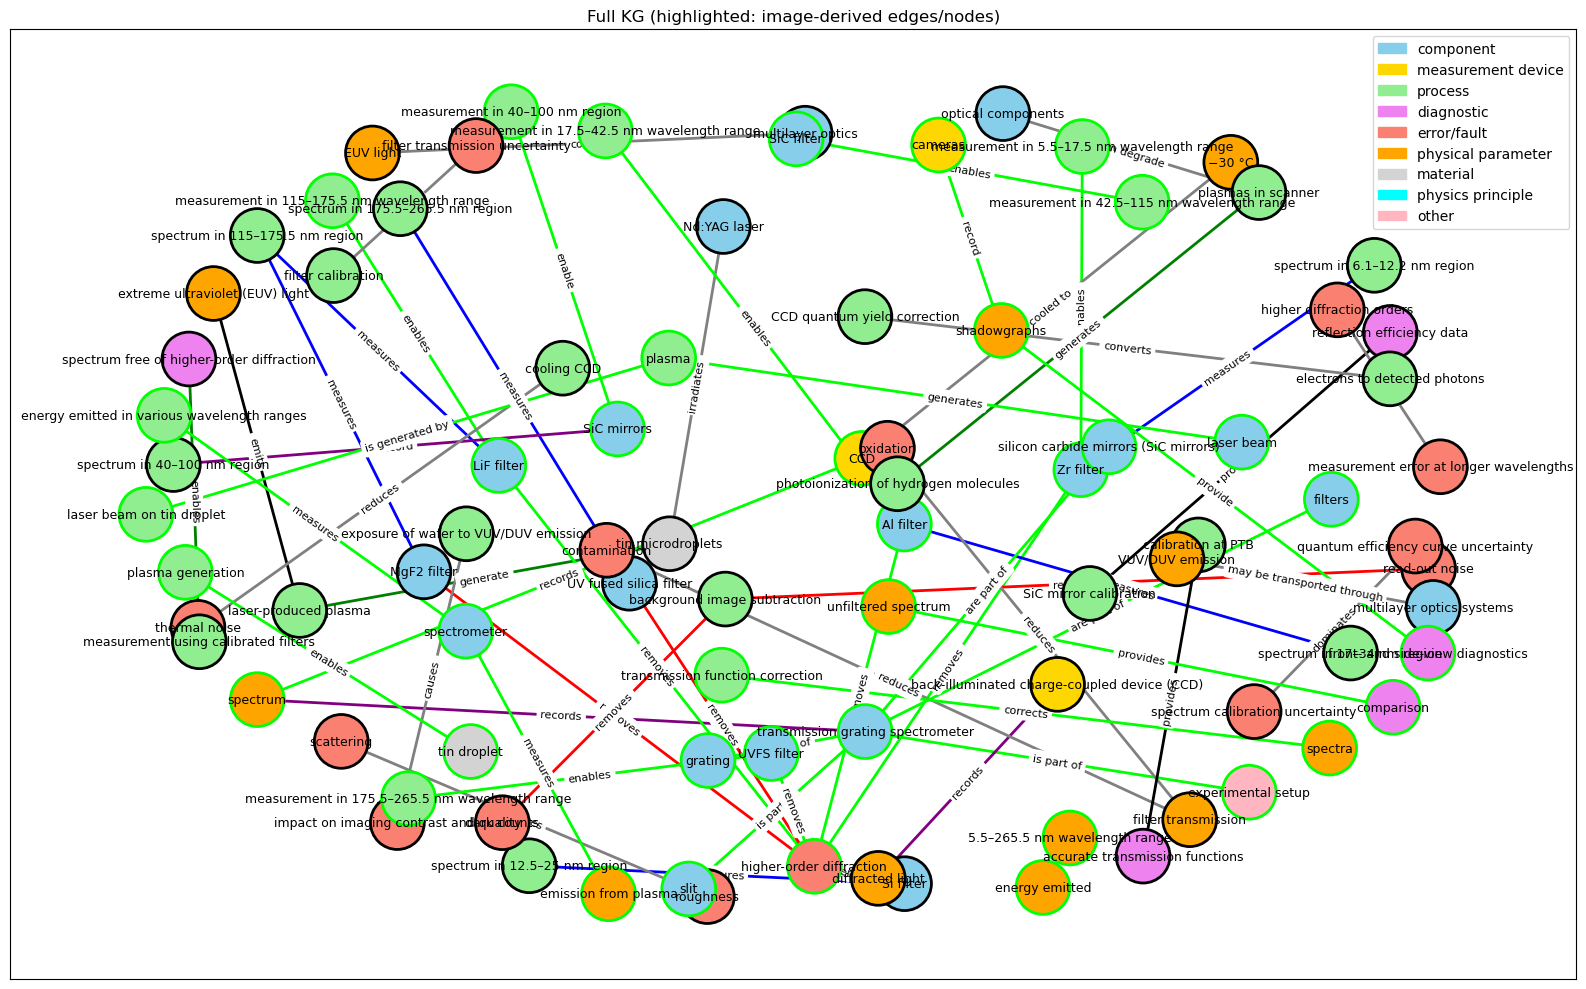

In [26]:
plot_kg(
    G,
    title="Full KG (highlighted: image-derived edges/nodes)",
    node_type_color=type_color,
    edge_type_color=relation_color,
    highlight_sources=image_sources,
    highlight_provenance=True
)

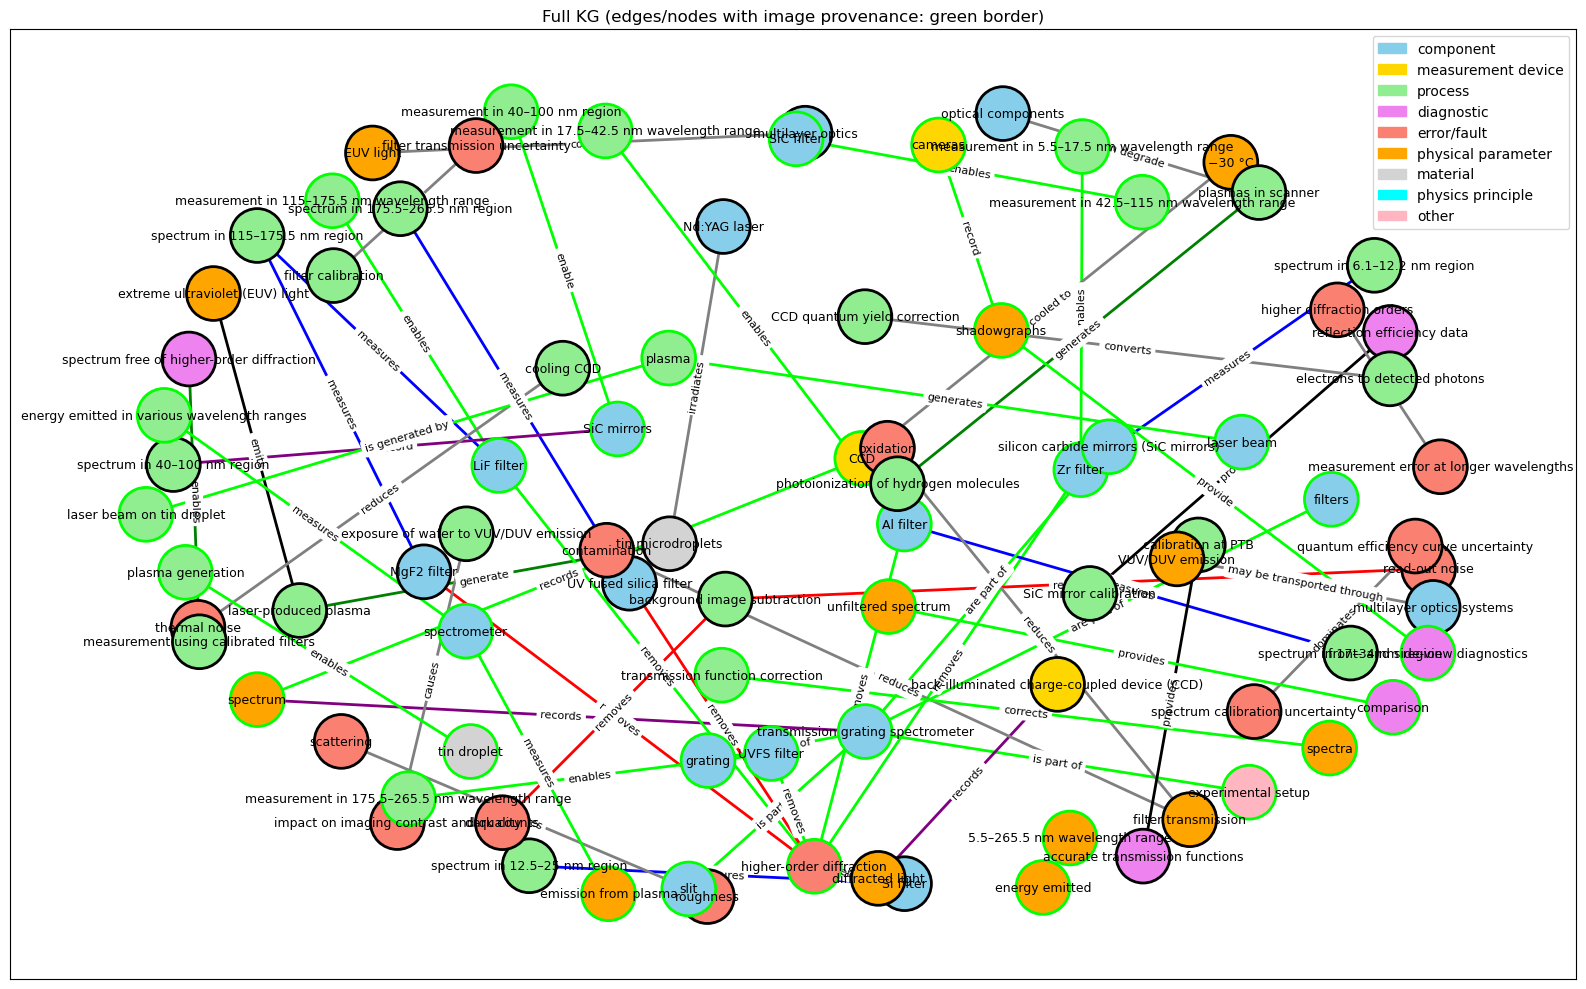

In [27]:
# This will add a lime border to all nodes/edges with image provenance
plot_kg(
    G,
    title="Full KG (edges/nodes with image provenance: green border)",
    node_type_color=type_color,
    edge_type_color=relation_color,
    highlight_sources=image_sources,
    provenance_color="lime",
    highlight_provenance=True
)


In [ ]:
##### Test openai call with a single image
image_path = paths_to_images[0]
base64_image = encode_image(image_path)

# client = OpenAI(api_key=OPENAI_API_KEY)

# response = client.responses.create(
#     model="gpt-4.1",
#     input=[
#         {
#             "role": "user",
#             "content": [
#                 { "type": "input_text", "text": "what's in this image?" },
#                 {
#                     "type": "input_image",
#                     "image_url": f"data:image/jpeg;base64,{base64_image}",
#                 },
#             ],
#         }
#     ],
# )

# print_response_stats(response)

# print(response.output_text)

In [45]:
##### Define response structure with pydantic classes and generate prompts
class SROWithMetadata(BaseModel):
    subject: str
    subject_type: str | None
    relation: str
    relation_type: str | None
    object: str
    object_type: str | None

class ExtractionTemplate(BaseModel):
    subject_relation_object: list[SROWithMetadata]

prompt_text = f"""
I am building a structured knowledge graph from the technical content of this academic paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.

**Text:**
{raw_text}
"""

prompt_image = f"""
I am building a structured knowledge graph from the technical content of an academic paper on EUV spectroscopy. Here is a figure from the paper.

**Your task:**  
Extract all relevant (subject, relation, object) triples from the following text, focusing on physical components, processes, measurements, diagnostics, or errors/faults. For each subject, relation, and object, assign a type. Avoid generic entities such as "it", "we", numbers, or section titles.

**Allowed types for subject/object:**
- component (e.g., filter, mirror, CCD, spectrometer)
- measurement device
- process (e.g., calibration, measurement, correction)
- physical parameter (e.g., wavelength, thickness)
- material
- diagnostic
- error/fault (e.g., noise, contamination, higher-order diffraction)
- physics principle (e.g., quantum yield, diffraction)
- other (if none of the above fits)

**Allowed types for relation:**  
- enables
- blocks
- measures
- removes
- records
- provides
- is type of
- causes
- calibrates
- corrects
- is part of
- other (if unsure)

**Return a list of dictionaries with this structure:**
{{
    "subject": <string>,
    "subject_type": <string or None>,
    "relation": <string>,
    "relation_type": <string or None>,
    "object": <string>,
    "object_type": <string or None>
}}

**Good examples:**
{{
    "subject": "Zr filter",
    "subject_type": "component",
    "relation": "removes",
    "relation_type": "removes",
    "object": "higher-order diffraction",
    "object_type": "error/fault"
}},
{{
    "subject": "four silicon carbide mirrors (SiC mirrors)",
    "subject_type": "component",
    "relation": "enable",
    "relation_type": "enables",
    "object": "measurement in 40–100 nm region",
    "object_type": "process"
}},
{{
    "subject": "CCD",
    "subject_type": "measurement device",
    "relation": "records",
    "relation_type": "records",
    "object": "spectrum",
    "object_type": "physical parameter"
}}

**Bad examples:**
{{
    "subject": "we",
    "subject_type": None,
    "relation": "find",
    "relation_type": None,
    "object": "agreement",
    "object_type": None
}}
{{
    "subject": "section",
    "subject_type": None,
    "relation": "contains",
    "relation_type": None,
    "object": "data",
    "object_type": None
}}
{{
    "subject": "it",
    "subject_type": None,
    "relation": "is",
    "relation_type": None,
    "object": "shown",
    "object_type": None
}}

**Further instructions:**
- Only extract triples involving key components, measurement devices, filters, diagnostics, errors, or physical processes.
- Use the full name for any element with an acronym on first occurrence, and use the full name thereafter.
- If a triple is ambiguous or too generic, skip it.
- Prefer the most specific type from the allowed list.
- Output results as a list of dictionaries, nothing else.
"""

In [ ]:
##### Setup enviornment for openai call
model_alias = "gpt-4.1"
true_model = MODEL_ALIASES[model_alias]
print(f"True model: {true_model}")

messages = [
        {"role": "user", "content": prompt_text},
    ]
client = OpenAI(api_key=OPENAI_API_KEY)

True model: gpt-4.1-2025-04-14


In [56]:
##### Perform openai call on raw text
start = time.perf_counter()
print("API call (client.responses.parse) sent")
response = client.responses.parse(
    model=true_model,
    input=messages,
    text_format=ExtractionTemplate
)

end = time.perf_counter()
print(f"API call (client.responses.parse) completed; time elapsed: {end - start:.2f}s")
print("-"*50)
##### Calculate response cost, and print #####
print_response_stats(response)

rdict = response.output_parsed.model_dump()

API call (client.responses.parse) sent
API call (client.responses.parse) completed; time elapsed: 18.55s
--------------------------------------------------
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 12982
Response output tokens: 1890
Estimated input token cost: $0.0260
Estimated output token cost: $0.0151
Total estimated cost: $0.0411


In [66]:
SRO_list = []
SRO_keys = [
    "subject",
    "subject_type",
    "relation",
    "relation_type",
    "object",
    "object_type"
]

for i in range(len(rdict["subject_relation_object"])):
    temp = []
    for key in SRO_keys:
        temp.append(rdict["subject_relation_object"][i][key])
    SRO_list.append(temp)

# Add provenance to text SROs
SRO_list_with_provenance = []
for sro in SRO_list:
    sro_with_prov = sro + ["text"]
    SRO_list_with_provenance.append(sro_with_prov)

# Now SRO_list_with_provenance contains lists of length 7
# Use this as your new master SRO_list
SRO_list = SRO_list_with_provenance
SRO_keys_with_provenance = SRO_keys + ["source"]

In [58]:
def extract_sro_from_image(image_path, prompt, client, model, ExtractionTemplate, image_tag=None):
    """
    Runs the OpenAI extraction on an image and returns the SRO triples as a list of lists.
    Optionally tags each triple with the image name as provenance.
    """
    base64_image = encode_image(image_path)
    # Compose the message for the multimodal model
    messages = [
        {"role": "user",
         "content": [
             {"type": "input_text", "text": prompt},
             {"type": "input_image", "image_url": f"data:image/png;base64,{base64_image}"}
         ]}
    ]
    response = client.responses.parse(
        model=model,
        input=messages,
        text_format=ExtractionTemplate
    )
    # Optionally print stats, inspect response
    print(f"Image: {os.path.basename(image_path)}")
    print_response_stats(response)
    rdict = response.output_parsed.model_dump()

    SRO_keys = [
        "subject",
        "subject_type",
        "relation",
        "relation_type",
        "object",
        "object_type"
    ]
    triples = []
    for sro in rdict["subject_relation_object"]:
        row = [sro[key] for key in SRO_keys]
        if image_tag:
            row.append(image_tag)   # add simple provenance
        triples.append(row)
    return triples

# Optionally, define an extended SRO_keys list if using provenance:
SRO_keys_with_provenance = SRO_keys + ["source"]

# If you want to record the provenance:
add_provenance = True  # set False to skip

if add_provenance:
    SRO_list = [[*row, "text"] for row in SRO_list]  # tag text provenance too

# ----- Image extraction -----
for img_idx, img_path in enumerate(paths_to_images):
    image_tag = os.path.splitext(os.path.basename(img_path))[0]  # e.g., "2021Bouza_fig1"
    sros = extract_sro_from_image(
        img_path, 
        prompt_image, 
        client, 
        true_model, 
        ExtractionTemplate, 
        image_tag if add_provenance else None
    )
    SRO_list.extend(sros)


Image: 2021Bouza_fig1.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1302
Response output tokens: 566
Estimated input token cost: $0.0026
Estimated output token cost: $0.0045
Total estimated cost: $0.0071
Image: 2021Bouza_fig5.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1642
Response output tokens: 408
Estimated input token cost: $0.0033
Estimated output token cost: $0.0033
Total estimated cost: $0.0065
Image: 2021Bouza_table2.png
Response alias model: gpt-4.1
Response true model: gpt-4.1-2025-04-14
Response input tokens: 1302
Response output tokens: 463
Estimated input token cost: $0.0026
Estimated output token cost: $0.0037
Total estimated cost: $0.0063


In [61]:
if add_provenance:
    G = nx.DiGraph()
    for row in SRO_list:
        s, s_type, r, r_type, o, o_type, source = row
        G.add_node(s, ntype=s_type, source=source)
        G.add_node(o, ntype=o_type, source=source)
        G.add_edge(s, o, label=r, rtype=r_type, source=source)
else:
    G = nx.DiGraph()
    for row in SRO_list:
        s, s_type, r, r_type, o, o_type = row
        G.add_node(s, ntype=s_type)
        G.add_node(o, ntype=o_type)
        G.add_edge(s, o, label=r, rtype=r_type)

In [ ]:
# G = nx.DiGraph()
# for s, s_type, r, r_type, o, o_type in SRO_list:
#     G.add_node(s, ntype=s_type)
#     G.add_node(o, ntype=o_type)
#     G.add_edge(s, o, label=r, rtype=r_type)

ValueError: too many values to unpack (expected 6)

In [62]:
type_color = {
    "component": "skyblue",
    "measurement device": "gold",
    "process": "lightgreen",
    "diagnostic": "violet",
    "error/fault": "salmon",
    "physical parameter": "orange",
    "material": "lightgrey",
    "physics principle": "aqua",
    "other": "lightpink",
    None: "grey"
}

node_colors = [type_color.get(G.nodes[n].get("ntype"), "grey") for n in G.nodes]

In [63]:
relation_color = {
    "enables": "green",
    "removes": "red",
    "measures": "blue",
    "records": "purple",
    "provides": "black",
    "calibrates": "brown",
    "other": "grey",
    None: "grey"
}
edge_colors = [relation_color.get(G.edges[e].get("rtype"), "grey") for e in G.edges]

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_42424/2836711819.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


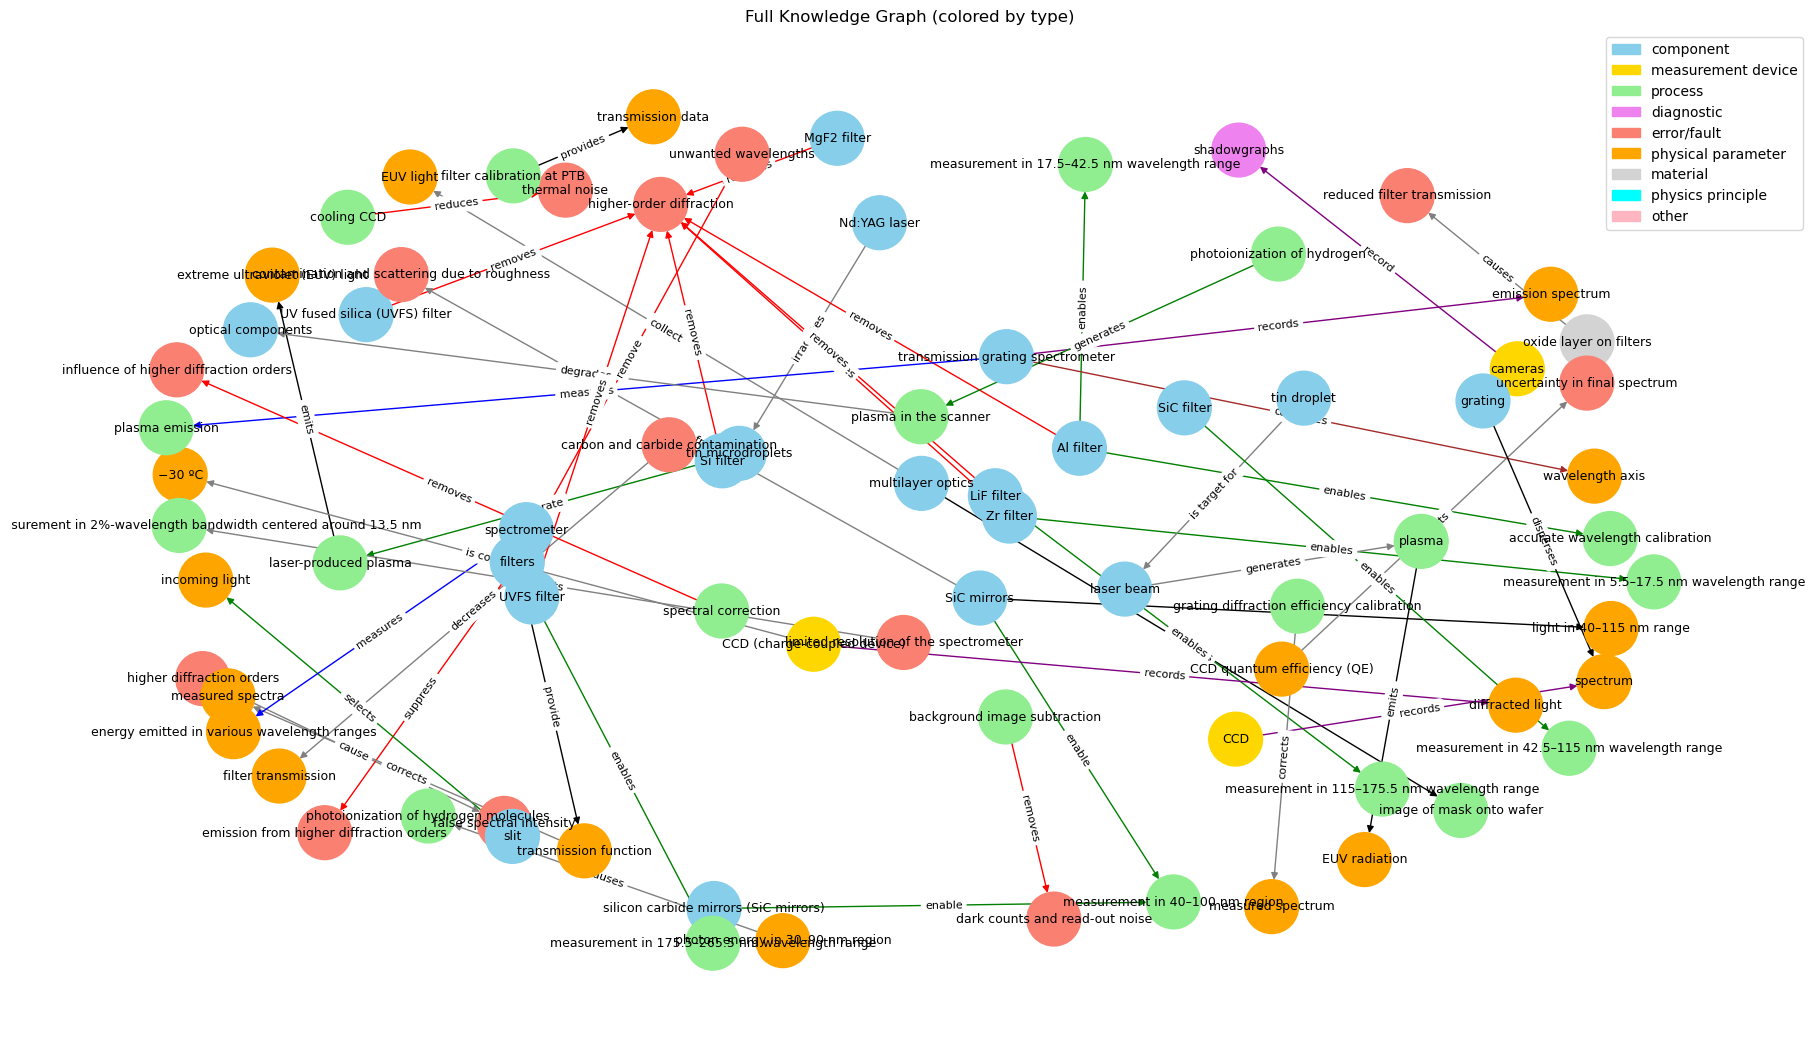

In [64]:
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G, k=0.6, seed=42)  # fixed seed for reproducibility

nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=1500,
    font_size=9
)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Full Knowledge Graph (colored by type)")
plt.tight_layout()
legend_handles = [Patch(color=color, label=typ) for typ, color in type_color.items() if typ]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1))
plt.show()

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_46366/1900116071.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


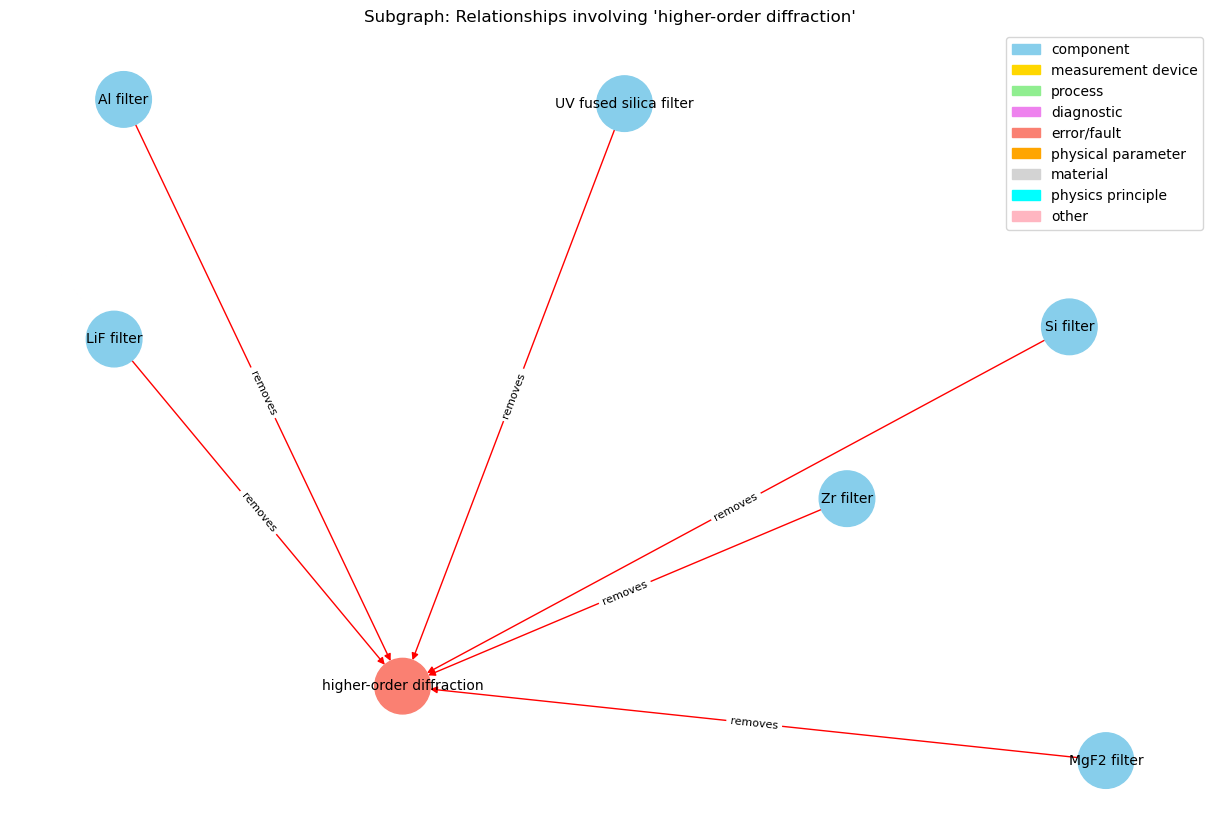

In [26]:
target_node = "higher-order diffraction"
sub_nodes = set([target_node])
for u, v in G.edges:
    if target_node in (u, v):
        sub_nodes.add(u)
        sub_nodes.add(v)
subG = G.subgraph(sub_nodes)
sub_node_colors = [type_color.get(subG.nodes[n].get("ntype"), "grey") for n in subG.nodes]
sub_edge_colors = [relation_color.get(subG.edges[e].get("rtype"), "grey") for e in subG.edges]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.6, seed=44)
nx.draw(
    subG, pos,
    with_labels=True,
    node_color=sub_node_colors,
    edge_color=sub_edge_colors,
    node_size=1600,
    font_size=10
)
edge_labels = nx.get_edge_attributes(subG, 'label')
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=8)
plt.title(f"Subgraph: Relationships involving '{target_node}'")
legend_handles = [Patch(color=color, label=typ) for typ, color in type_color.items() if typ]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()